In [1]:
%load_ext autoreload
%autoreload 1
%aimport src
%aimport src.utils
%aimport src.SdmIsmAnalysis
%aimport src.SimpleSynthesis

# display last assigned variable automatically
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

%matplotlib inline
from matplotlib.pyplot import *

from src.utils import mygrid

import seaborn as sns
import polars as pl
import numpy as np
import scipy
from pathlib import Path

In [2]:
raw = pl.read_csv("../webMUSHRA-1.4.3/results/bs1116_nonextrapolating/bs1116.csv")

session_test_id,trial_id,rating_reference,rating_non_reference,rating_reference_score,rating_non_reference_score,rating_time,choice_comment
str,str,str,str,f64,f64,i64,str
"""bs1116_nonextr…","""trial0""","""reference""","""C1""",5.0,5.0,32594,null
"""bs1116_nonextr…","""trial1""","""reference""","""C1""",5.0,4.56,83205,null
"""bs1116_nonextr…","""trial2""","""reference""","""C1""",5.0,1.72,17373,null
"""bs1116_nonextr…","""trial3""","""reference""","""C1""",4.8,5.0,54144,null
"""bs1116_nonextr…","""trial4""","""reference""","""C1""",5.0,4.8,101104,null
…,…,…,…,…,…,…,…
"""bs1116_nonextr…","""trial15""","""reference""","""C1""",5.0,2.76,60610,null
"""bs1116_nonextr…","""trial16""","""reference""","""C1""",5.0,5.0,27020,null
"""bs1116_nonextr…","""trial17""","""reference""","""C1""",4.8,5.0,136683,null


In [8]:
df = raw.select(
    trial = pl.col("trial_id").str.slice(5).str.to_integer(),
    delta = pl.col("rating_non_reference_score") - pl.col("rating_reference_score")
)

trial,delta
i64,f64
0,0.0
1,-0.44
2,-3.28
3,0.2
4,-0.2
…,…
15,-2.24
16,0.0
17,0.2


In [22]:
trials_exp_order = [14, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 12, 15, 16, 17, 18, 19]

[14, 11, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 12, 15, 16, 17, 18, 19]

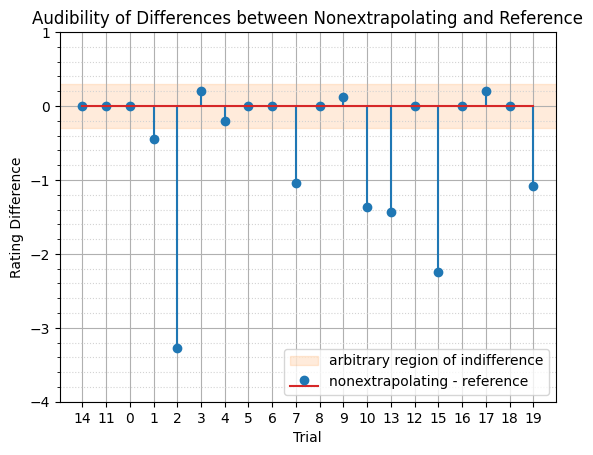

In [53]:
stem(range(20), df["delta"][trials_exp_order].to_numpy().squeeze(), label="nonextrapolating - reference")
xticks(range(20), trials_exp_order)
ylim(-4, 1)
# todo change to fill
gca().autoscale(False)
fill_between([-10, 100], [-.3, -.3], [.3, .3], alpha=.15, color="C1", label="arbitrary region of indifference")
#axhline(-.3, color="black", alpha=.7, linestyle="--", label="arbitrary limits of indifference")
#axhline(+.3, color="black", alpha=.7, linestyle="--")
legend(loc="lower right")
minorticks_on()
gca().tick_params(axis='x', which='minor', bottom=False)
grid(True, which="major", axis="both")
grid(True, which="minor", axis="y", color="lightgrey", linestyle=":")
xlabel("Trial")
ylabel("Rating Difference")
title("Audibility of Differences between Nonextrapolating and Reference")
savefig("../reports/figures/bs1116-results.pdf")

(-4.0, 1.0)

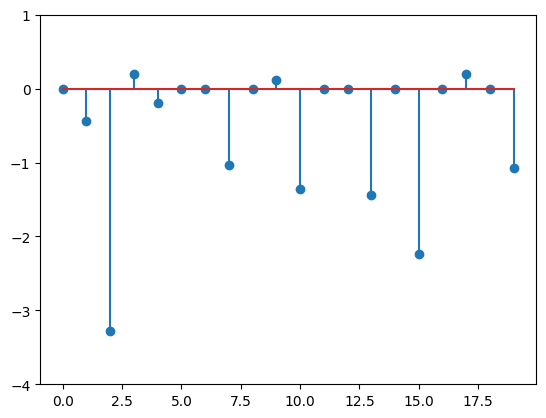

In [27]:
stem(df["trial"].to_numpy().squeeze(), df["delta"].to_numpy().squeeze())
ylim(-4, 1)

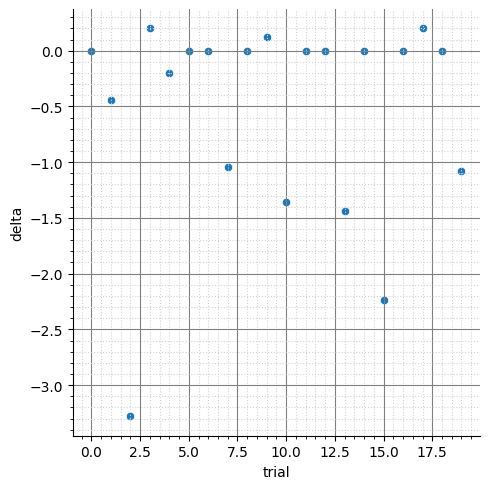

In [14]:
sns.relplot(df, x="trial", y = "delta")
mygrid()

In [4]:
1+1

2